In [1]:
import Bio.bgzf as bgzf
import pysam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.stats.api as sms
import scipy.stats as st
import seaborn as sns
from IPython.display import display, HTML
from time import time


from collections import defaultdict, Counter
from operator import itemgetter
from itertools import groupby
import re

# Домашка 2. Выравнивание коротких ридов.
## Часть а. Анализ ридов Illumina

### Данные

Тестовый датасет: `test_1.fastq, test_2.fastq`<br>
Тестовый геном: `MG1655-K12.first10K.fasta`

Если ваша фамилия начинается на М-Я (моя фамилия на букву Ч):<br>
Датасет №1: `B.faecium/frag.R1.fastq.gz`, `B.faecium/frag.R2.fastq.gz`<br>
Датасет №2: `B.faecium/jump.R1.fastq.gz`, `B.faecium/jump.R2.fastq.gz`<br>
Референсный геном: `B.faecium/ref.fasta.gz*`<br>

Поехали!

#### 0. Разбораться с `Bowtie2` / `bwa mem`
Построить индекс, запустить любой из тулов на ваш выбор, определить процент приложившихся ридов (`samtools flagstat`). 

Выберу `bwa`.
<br>
Установим `bwa` and `samtools`
```
sudo apt-get install bwa
sudo apt-get install samtools
```
Далее, начнем работу с тестом:
индексируем, выравниваем, декобируем в бам и чекаем статистику:
```
$ bwa index MG1655-K12.first10K.fasta 
$ bwa mem MG1655-K12.first10K.fasta test_1.fastq test_2.fastq > alignment.sam
$ samtools view -S -b alignment.sam > alignment.bam
$ samtools flagstat alignment.bam
56320 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
56320 + 0 mapped (100.00% : N/A)
56320 + 0 paired in sequencing
28160 + 0 read1
28160 + 0 read2
56280 + 0 properly paired (99.93% : N/A)
56320 + 0 with itself and mate mapped
0 + 0 singletons (0.00% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

```
т.е. замапилось 99.93 процента

Для нормальных датасетов аналогично:
```
bwa index ref.fasta
bwa mem ref.fasta jump.R1.fastq jump.R2.fastq > alignment_jump.sam
samtools view -S -b alignment_jump.sam > alignment_jump.bam
bwa mem ref.fasta frag.R1.fastq frag.R2.fastq > alignment_frag.sam
samtools view -S -b alignment_frag.sam > alignment_frag.bam

```


### 1. Покрытие генома.
По SAM файлу:
* построить график покрытия генома, 
* определить среднее покрытие и долю покрытой области генома. 

Покрытие одной позиции в геноме есть количество ридов, приложившихся так, что их концы находятся по разные стороны от этой позиции. График можно строить усредняя, например, по 1000 нуклеотидов. 

Доля покрытой области генома определяется как процент нуклеотидов с ненулевым покрытием по отношению ко всей длине генома.

In [2]:
##### Подсчет покрытия
# Функция очень просто считает по строке cigar покрытие 
# возвращает массив "покрытие на каждый нуклеотид".
def count_cov(bam_file_path):
    
    bamfile = pysam.AlignmentFile(bam_file_path, 'rb')
    length = bamfile.lengths[0]
    
    
    base_cov = np.array([0 for i in range(length+1)])
    count = 0
    ex_counter = 0
    for read in bamfile:
        try:
            count += 1
            if count % 100000 == 0:
                print(count, end = ' ')
            if not read.is_unmapped:
                start = read.reference_start
                for tup in read.cigar:
                    s = start
                    f = start + tup[1]
                    if tup[0] == 8 or tup[0] == 7 or tup[0] == 1 or tup[0] == 0:  
                        for i in range(s, f):
                            base_cov[i] += 1
                    start = f
        except:
            ex_counter += 1
    print('\nРиды, при чтении которых возникла ошибка: '+str(ex_counter))
    return base_cov

#### Подсчет длины референсного генома.
# Берем из информационной строки sam-файла
def read_len(sam):
    samfile = open(sam, 'r')
    line_0 = samfile.readline()
    samfile.close()
    ln = int(line_0.split('\t')[2].replace('LN:',''))
    return ln

#### График покрытия генома

def draw_coverage(cov):
    length = len(cov)//1000 + 1
    new_cov = []
    positions = []
    for i in range(length):
        positions.append(i*1000)
        if i!=length-1:
            new_cov.append(np.average(cov[i*1000:(i+1)*1000]))
        else:
            new_cov.append(np.average(cov[i*1000:len(cov)]))
    positions = np.array(positions)
    new_cov = np.array(new_cov)
    plt.plot(positions, new_cov, linestyle="-", color = 'red')
    plt.show()
    
#### Среднее покрытие и доля покрытой области генома
def cov_stat(cov):
    avg = np.average(cov)
    zero_amount = np.count_nonzero(avg == 0)
    part_of_cov = 1 - zero_amount/len(cov)
    return avg, part_of_cov

##### Запустим на тесте!


Риды, при чтении которых возникла ошибка: 0
Среднее покрытие:508.92380761923806
Доля покрытия:1.0


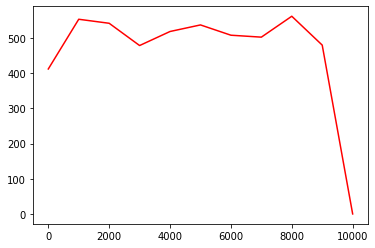

In [3]:
# Прочитаем файл, 

bam_test = 'data/test/alignment.bam'

# Посчитаем покрытие и статистики
coverage_test = np.array(count_cov(bam_test))
average_cov_test, part_of_cov_test = cov_stat(coverage_test)

# Выведем
print('Среднее покрытие:'+str(average_cov_test))
print('Доля покрытия:'+str(part_of_cov_test))

#Нарисуем график покрытия
draw_coverage(coverage_test)

### 2. Распределение расстояния вставки.
По SAM файлу:
* построить график распределения расстояния вставки, 
* определить среднее расстояние вставки, среднеквадратичное отклонение и интервал минимальной ширины, в который попадает 95% ридов. 

На графике по оси Х должно быть расстояние вставки, по оси Y — количество ридов в заданным расстоянием вставки.


In [4]:
#### Функция, возвращающая массив длин вставок
def insertion(bam_file_path):
    bam_file = pysam.AlignmentFile(bam_file_path, 'rb')
    ins = []
    count = 0
    for read in bam_file:
        count += 1
        if count % 100000 == 0:
            print(count, end = ' ')
        if not read.mate_is_unmapped:
            ins.append(abs(read.tlen))
    return  np.array(ins)


#### Посчитаем всякие нужные статистики
def count_stat(row):
    mean = np.mean(row)
    standart_d = np.std(row)
    interval = (np.percentile(row, 2.5), np.percentile(row, 97.5))
    treshold = np.percentile(row, 99) if np.percentile(row, 99)< 5000 else 5000
    sns.distplot(row[row<treshold])
    plt.show()
    return mean, standart_d, interval

##### Запустим на тесте

Посчитаем и выведем все, что нужно

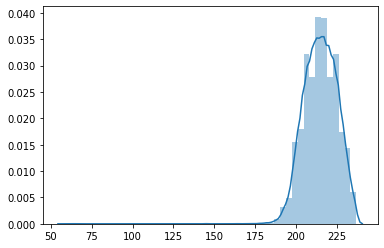

Cреднее расстояние вставки: 215.2860440340909
Cреднеквадратичное отклонение: 10.590040942453138
Интервал минимальной ширины, в который попадает 95% ридов: (196.0, 234.0)


In [5]:
# Прочитаем файл, 
bam_test = 'data/test/alignment.bam'

insert_test = insertion(bam_test)
mean_test, standart_d_test, interval_test = count_stat(insert_test)

# Выведем
print('Cреднее расстояние вставки: '+str(mean_test))
print('Cреднеквадратичное отклонение: '+str(standart_d_test))
print('Интервал минимальной ширины, в который попадает 95% ридов: '+str(interval_test))

### 3. Частоты различных замен
Построить матрицу частот замен (A,C,G,T).
Так, в ячейке (А,С) должно стоять количество ошибок замены С на А (С в референсе, А в риде). Определить средний процент ошибок в ридах.

In [6]:
def substitutions(bam_file_path):
    bam_file = pysam.AlignmentFile(bam_file_path, 'rb')
#     for i, read in enumerate(bam_file):
#         print(i, read)
    letter_to_digit = {'A':0, 'C':1, 'G':2, 'T':3}
    digit_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
    substitutions = [[0 for x in range(4)] for y in range(4)]
    sum_length = 0
    for read in bam_file:
        try:
            if not (read.is_supplementary and read.is_unmapped):
                ref_seq = read.get_reference_sequence()
                read_seq = read.query_alignment_sequence
                key_errors = 0
                for ref_l, read_l in zip(ref_seq, read_seq):
                    ref_l, read_l = ref_l.upper(), read_l.upper()
                    try:
                        if ref_l.upper() != read_l.upper():
                            substitutions[letter_to_digit[read_l]][letter_to_digit[ref_l]]+=1
                    except KeyError:
                        key_errors+=1
                sum_length += len(ref_seq)-key_errors
        except ValueError:
            continue

        
            
    print(to_df(substitutions))
    print(f'Процент ошибок: {sum(sum(np.array(substitutions)))/sum_length*100} %')

def to_df(substitutions):
    numpy_data = np.array(substitutions)
    df = pd.DataFrame(data=numpy_data, index=['A', 'C', 'G', 'T'], columns=['A', 'C', 'G', 'T'])
    return df

In [7]:
substitutions(bam_test)

    A  C   G   T
A   0  0   0   0
C  15  0  21   0
G  19  2   0  16
T   1  1  34   0
Процент ошибок: 0.0021415602779470177 %


In [8]:
def run(bam):
    # ПОКРЫТИЕ
    print('COVERAGE\n')
    # Посчитаем покрытие и статистики
    coverage = np.array(count_cov(bam))
    average_cov, part_of_cov = cov_stat(coverage)

    # Выведем
    print('Среднее покрытие:'+str(average_cov))
    print('Доля покрытия:'+str(part_of_cov))

    #Нарисуем график покрытия
    draw_coverage(coverage)
    print('=====================')


    # РАССТОЯНИЕ ВСТАВКИ
    print('\nINSERTION DISTANCE\n')
    insert = insertion(bam)

    mean, standart_d, interval = count_stat(insert)
    # Выведем
    print('Cреднее расстояние вставки: '+str(mean))
    print('Cреднеквадратичное отклонение: '+str(standart_d))
    print('Интервал минимальной ширины, в который попадает 95% ридов: '+str(interval))

    print('=====================')

    # ЗАМЕНЫ
    print('\nSUBSTITUTIONS\n')
    substitutions(bam)


### Запустим на real data!

COVERAGE

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 3500000 3600000 3700000 3800000 3900000 4000000 4100000 4200000 4300000 
Риды, при чтении которых возникла ошибка: 47
Среднее покрытие:124.75544205906957
Доля покрытия:1.0


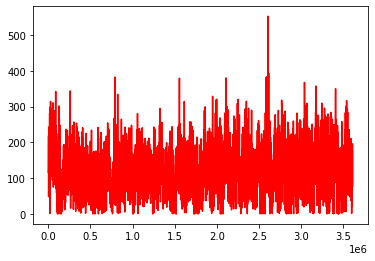


INSERTION DISTANCE

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 3500000 3600000 3700000 3800000 3900000 4000000 4100000 4200000 4300000 

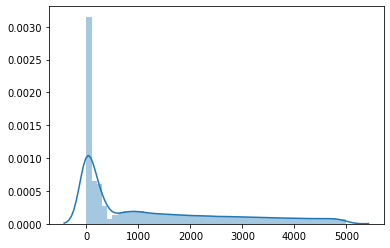

Cреднее расстояние вставки: 123755.02140813344
Cреднеквадратичное отклонение: 461252.2474377679
Интервал минимальной ширины, в который попадает 95% ридов: (1529.0, 1814088.9499999997)

SUBSTITUTIONS

        A       C       G       T
A       0  181760  120363   54794
C  911468       0  576392  554975
G  557167  588576       0  924135
T   60223  117102  181465       0
Процент ошибок: 1.070630985722677 %


In [9]:
run('data/B.faecium/alignment_jump.bam')


COVERAGE

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 
Риды, при чтении которых возникла ошибка: 23
Среднее покрытие:130.59156894399766
Доля покрытия:1.0


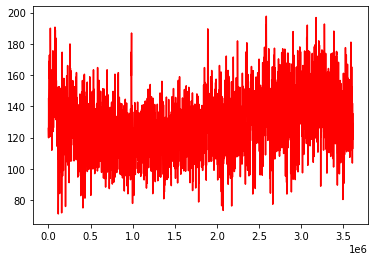


INSERTION DISTANCE

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 

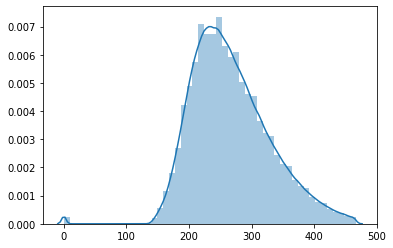

Cреднее расстояние вставки: 2360.175803007425
Cреднеквадратичное отклонение: 63249.24492436618
Интервал минимальной ширины, в который попадает 95% ридов: (172.0, 425.0)

SUBSTITUTIONS

         A        C        G        T
A        0   663614   325952   136337
C  1556651        0  1367740   946758
G   951439  1370383        0  1566515
T   133859   325154   665738        0
Процент ошибок: 2.120476278154807 %


In [10]:
run('data/B.faecium/alignment_frag.bam')

## Часть b. Анализ ридов IonTorrent
### Данные: 
Тестовые данные: `test.fastq`, `test_reference.fasta`

Данные: `B22-730.fastq.gz`, `C24-698.fastq.gz`

Референсный геном: `DH10B-K12.fasta`

Обработаем (тестовый не заработал ваще):
```
$ bwa index DH10B-K12.fasta 
$ bwa mem DH10B-K12.fasta B22-730.fastq >alignment_B.sam
$ samtools view -S -b alignment_B.sam > alignment_B.bam
$ bwa mem DH10B-K12.fasta C24-698.fastq >alignment_C.sam
$ samtools view -S -b alignment_C.sam > alignment_C.bam

```

### 1. Статистика ридов IonTorrent
С помощью посчитать следующие статистики для ридов:
* Покрытие генома (график, процент покрытого генома, среднее покрытие)
* Средний процент ошибок в ридах
* Статистика длин инделов
* Статистика длин инделов в завимости от длины гомополимерного участка (участок состоящий из одного типа нуклеотидов, например АААААААА). Мы фиксируем длину гомополимерного участка (пусть 5bp), и находим все гомополимеры такой длины в референсе. Дальше смотрим как участки этой длины прочитались секвенатором. Смотрим сколько раз прочиталось 3bp, 4bp, 5bp, 6bp и итд. Повторяем это для гомополимеров всех длин (например, от 3 до 20).
* Статистика качества нуклеотидов
    * при ошибочно вставленном нуклеотиде
    * при замене
* Таблица частот замен/вставок/удалений


In [11]:
#ПОКРЫТИЕ
def count_stats(bam_file_path):    
    # покрытие:
    coverage = np.array(count_cov(bam_file_path))
    average_cov, part_of_cov = cov_stat(coverage)
    print('Среднее покрытие:'+str(average_cov))
    print('Доля покрытия:'+str(part_of_cov))
    draw_coverage(coverage)


#     ошибки в ридах    
def errors(bam_file_path):
    
    tic = time()
    bam_file = pysam.AlignmentFile(bam_file_path, 'rb')
    
    # счетчики ошибок и мисматчей, общей длины ридов и количества ридов
    error_counter = 0
    mismatch_counter = 0
    reference_length = 0
    file_length = 0
    # статистика инделов по  гомополимерам
    homo_stat = [[0]*20 for i in range(20)]
    # качества нуклеотидов при замене и вставке.
    mismatch_quality = []
    insertion_quality = []
    # счетчик длин инделов
    insertions = defaultdict(int)
    deletions = defaultdict(int)
    try:
        for read in bam_file:
            if read.is_unmapped or read.is_supplementary or not read.has_tag('MD'): 
                continue

            quality = read.query_alignment_qualities
            seq = read.seq
            ref_seq = read.get_reference_sequence()
            cigar = read.cigarstring

            # (start_index; length; letter)
            a_h = [(m.start(0), m.end(0)-m.start(0)-2, 'A') for m in re.finditer("[^A][A]{3,20}[^A]", '$'+ref_seq +'$')]
            t_h = [(m.start(0), m.end(0)-m.start(0)-2, 'T') for m in re.finditer("[^T][T]{3,20}[^T]", '$'+ref_seq +'$')]
            g_h = [(m.start(0), m.end(0)-m.start(0)-2, 'G') for m in re.finditer("[^G][G]{3,20}[^G]", '$'+ref_seq +'$')]
            c_h = [(m.start(0), m.end(0)-m.start(0)-2, 'C') for m in re.finditer("[^C][C]{3,20}[^C]", '$'+ref_seq +'$')]
            indexes_h = []
            length_h = []
            letters_h = []
            def count_homo(indexes_h, length_h, letters_h, tuples):
                for ind, lent, letter in tuples:
                    indexes_h.append(ind)
                    length_h.append(lent)
                    letters_h.append(letter)
                return indexes_h, length_h, letters_h
            indexes_h, length_h, letters_h = count_homo(indexes_h, length_h, letters_h, a_h)
            indexes_h, length_h, letters_h = count_homo(indexes_h, length_h, letters_h, t_h)
            indexes_h, length_h, letters_h = count_homo(indexes_h, length_h, letters_h, g_h)
            indexes_h, length_h, letters_h = count_homo(indexes_h, length_h, letters_h, c_h)

            df = pd.DataFrame(data=np.array([indexes_h, length_h, letters_h]).T, columns=["indexes", "length", 'letters'])
            df[["indexes", "length"]] = df[["indexes", "length"]].apply(pd.to_numeric) 
            df = df.set_index('indexes')
            df.sort_index(inplace=True)       


            # В seq не учитывается 'D'
            # В ref_seq не учитывается 'I', 'S'
            # В quality - 'S' и 'D'
            pivot = 0
            d_counter = 0
            i_counter = 0
            s_counter = 0


            amount_of_checked = 0
            check_len = 0
            check_let = ''
            check_ind = 0

            for num, letter in re.findall('(\d+)([A-Za-z])', cigar):
                num = int(num)
                if letter == 'I':
                    begin = pivot - s_counter - d_counter
                    for i in range(begin, begin + num):
                        insertion_quality.append(quality[i])

                    b_seq = pivot - d_counter
                    for seq_l in seq[b_seq:b_seq+num]:
                        if check_len > 0:
                            amount_of_checked += 1
                            check_len -= 1
                            if check_len == 0:
                                homo_stat[check_len2][amount_of_checked] += 1
                                amount_of_checked = 0
                    insertions[num] += 1
                    i_counter += num
                elif letter == 'D':
                    b_ref = pivot - i_counter - s_counter

                    for ref_l, index in zip(ref_seq[b_ref:b_ref+num], range(b_ref,b_ref+num)):
                        if index in df.index:
                            amount_of_checked = 0
                            check_len, check_let = df.loc[index]
                            #одну будем убавлять, чтобы идти до нуля, а во второй хранить значение длины гомополимера
                            check_len2 = check_len
                        if check_len > 0:
                            check_len -= 1
                            if check_len == 0:
                                homo_stat[check_len2][amount_of_checked] += 1
                                amount_of_checked = 0

                    deletions[num] += 1
                    d_counter += num
                elif letter == 'M':
                    b_seq = pivot - d_counter
                    b_ref = pivot - i_counter - s_counter
                    b_qual = pivot - s_counter - d_counter
                    for seq_l, ref_l, q, index in zip(seq[b_seq:b_seq+num], ref_seq[b_ref:b_ref+num], quality[b_qual:b_qual+num], range(b_ref,b_ref+num)):

                        if index in df.index:
                            amount_of_checked = 0
                            check_len, check_let = df.loc[index]
                            #одну будем убавлять, чтобы идти до нуля, а во второй хранить значение длины гомополимера
                            check_len2 = check_len
                        if check_len > 0:
                            if seq_l == ref_l:
                                amount_of_checked += 1
                            check_len -= 1
                            if check_len == 0:
                                homo_stat[check_len2][amount_of_checked] += 1
                                amount_of_checked = 0

                        if seq_l != ref_l:
                            mismatch_counter += 1
                            mismatch_quality.append(q)
                elif letter == 'S':
                    s_counter += num        
                pivot += num


            if file_length%10000 == 0:
                print(file_length, end = ' ')
                print(f'{time()-tic} sec', end = ' ')
            reference_length += pivot
            file_length += 1
            error_counter += i_counter+d_counter
    except KeyboardInterrupt:
        pass
    error_counter += mismatch_counter              

    def average_indels(dictionary, read_amount, reads_length, name:str):
        amount = 0
        for key in dictionary:
            amount += dictionary[key]*key
            dictionary[key] /= read_amount
        print(f'Statistics of {name}')
        for key in dictionary:
            print(f'len = {key},\t {dictionary[key]} per read')
        return amount

    percentage_of_errors = error_counter/reference_length
    print()
    print(f'Average errors percentage: {percentage_of_errors*100}%')
    print('---')
    insertions_amount = average_indels(insertions, file_length, reference_length, 'insertions')
    deletions_amount = average_indels(deletions, file_length, reference_length, 'deletions')
    print('---')
    print(f'Total frequency of insertions = {insertions_amount/reference_length}')
    print(f'Total frequency of deletions = {deletions_amount/reference_length}')
    print(f'Total frequency of mismatches = {mismatch_counter/reference_length}')
    print('---')
    sns.distplot(mismatch_quality, label = 'quality of mismatch nucleotides')
    sns.distplot(insertion_quality, label = 'quality of insertion nucleotides')
    plt.legend()
    plt.show()
    print('---')
    print('Homopolymers\' stats (per read)')
    print('(По вертикали - длина гомополимера в референсе, по горизонтали - длина в риде)')
    display(pd.DataFrame(np.array(homo_stat)/file_length).iloc[3:,3:] )

### Check this out:

In [12]:
def run_2b(bam_file_path):
    start = time()
#     count_stats(bam_file_path)
    errors(bam_file_path)
    print(f'Time: {time()-start} sec')

0 0.02373790740966797 sec 10000 63.231521129608154 sec 20000 126.90593481063843 sec 30000 191.4812891483307 sec 40000 254.48784804344177 sec 50000 317.30577659606934 sec 60000 381.39127135276794 sec 70000 445.4508240222931 sec 80000 509.34994649887085 sec 90000 572.1352481842041 sec 100000 635.7889528274536 sec 110000 698.5643317699432 sec 120000 762.724992275238 sec 130000 822.8981993198395 sec 140000 882.9948256015778 sec 150000 946.2916350364685 sec 160000 1007.7991976737976 sec 170000 1070.053876876831 sec 180000 1131.935711145401 sec 190000 1193.2779397964478 sec 200000 1255.207096338272 sec 210000 1315.0978574752808 sec 220000 1374.385241985321 sec 230000 1433.940857410431 sec 240000 1492.681167125702 sec 250000 1551.7739741802216 sec 260000 1610.4468457698822 sec 270000 1670.3958988189697 sec 280000 1729.283276796341 sec 290000 1787.6621851921082 sec 300000 1846.2480511665344 sec 310000 1904.9050209522247 sec 320000 1966.0803203582764 sec 330000 2026.5118322372437 sec 340000 208

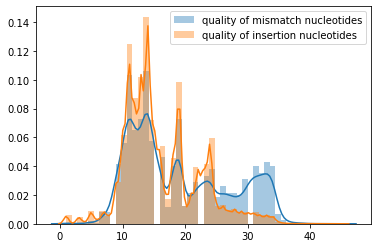

---
Homopolymers' stats (per read)
(По вертикали - длина гомополимера в референсе, по горизонтали - длина в риде)


,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
3,11.190638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.114535,2.908660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000663,0.073284,0.908326,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000037,0.000821,0.041861,0.253682,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000002,0.000064,0.000729,0.019347,0.050122,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.000000,0.000041,0.000497,0.003591,0.010351,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.000000,0.000000,0.000012,0.000074,0.000082,0.001086,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000018,0.000047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Time: 2981.129162788391 sec


In [13]:
run_2b('data/2b/alignment_B.bam')

### And another data

0 0.012744426727294922 sec 10000 54.14667773246765 sec 20000 107.66661024093628 sec 30000 161.42064476013184 sec 40000 216.06538319587708 sec 50000 269.86940264701843 sec 60000 325.92268538475037 sec 70000 381.3231906890869 sec 80000 438.0494966506958 sec 90000 494.97403740882874 sec 100000 551.378776550293 sec 110000 607.501277923584 sec 120000 663.2559196949005 sec 130000 718.8781554698944 sec 140000 773.1626217365265 sec 150000 826.3073155879974 sec 160000 879.9982199668884 sec 170000 934.2047333717346 sec 180000 988.3367590904236 sec 190000 1042.2336575984955 sec 200000 1096.7543992996216 sec 210000 1151.05907869339 sec 220000 1206.2030973434448 sec 230000 1260.4781081676483 sec 240000 1315.5713739395142 sec 250000 1370.6220030784607 sec 260000 1425.1777708530426 sec 270000 1479.7538647651672 sec 280000 1535.0150623321533 sec 290000 1590.305202960968 sec 300000 1644.8564808368683 sec 310000 1699.2836220264435 sec 320000 1753.8466470241547 sec 330000 1808.2624435424805 sec 340000 18

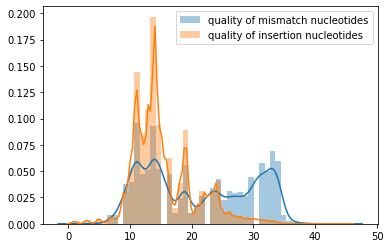

---
Homopolymers' stats (per read)
(По вертикали - длина гомополимера в референсе, по горизонтали - длина в риде)


,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
3,8.367638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.033098,2.191951,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000188,0.015919,0.697444,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000007,0.000160,0.009535,0.204219,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000003,0.000098,0.004950,0.045716,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.000000,0.000003,0.000050,0.001080,0.009981,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000003,0.000139,0.000775,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.000000,0.000000,0.000000,0.000001,0.000001,0.000003,0.000012,0.000021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Time: 3707.8424990177155 sec


In [14]:
run_2b('data/2b/alignment_C.bam')